In [63]:
import os
import json
import glob
import json
import pandas as pd
import numpy as np

In [64]:
def parse_result(path):
    line_list = open(path,'r').readlines()
    lines = [line.strip() for line in line_list]
    end_line = lines[-1].split(', ')
    best_eer = end_line[-1].split(' ')[-1]
    result = {}
    sum_minDCF = 0
    for i,line in enumerate(lines):
        try:
            cur_eer = line.split(', ')[-2].split(' ')[-1]
            cur_best_eer = line.split(', ')[-1].split(' ')[-1]
            if cur_eer == cur_best_eer == best_eer:
                for j in range(i-2,i):
                    splits = lines[j].split(', ')
                    gender = splits[0].split(' ')[-1]
                    eer = splits[1].split(' ')[-1]
                    minDCF = splits[2].split(' ')[-1]
                    result[gender] = {'eer': float(eer.split('%')[0]), 'minDCF': float(minDCF)}
                    sum_minDCF += float(minDCF)
        except :
            pass
    result['overall'] = {'eer': float(best_eer.split('%')[0]), 'minDCF': sum_minDCF/2}
    return result


In [98]:
LOOP = 4

In [99]:
for l in range(LOOP):
    files = glob.glob('./checkpoints_combine/loop%s/*/score-stage.txt'%(l+1))
    for file in files:
        result = parse_result(file)
        index = file.rfind('/')
        path = file[:index]
        name = 'dev_results.json'
        with open(os.path.join(path, name), 'w') as f:
            json.dump(result,f)

In [100]:
def concate_result(files, loop, store=False):
    data = {
        'phase': [],
        'eer': [],
        'gender': [],
        'minDCF': [],
        'text': [],
        'loop': [],
        'word': []
        }
    parse = files[0].split('/')
    path = '/'.join(parse[:-2])
    for file in files:
        res = json.load(open(file, 'r'))
        splits = file.split('/')
        if 'eval' in splits[-1]:
            phase = 'eval'
        else:
            phase = 'dev'
        text = splits[-2]
        word = text.split('_')[0]
        
        for g in res:
            data['gender'].append(g)
            data['eer'].append(res[g]['eer'])
            data['minDCF'].append(res[g]['minDCF'])
            data['phase'].append(phase)
            data['text'].append(text)
            data['loop'].append(loop)
            data['word'].append(word)
    df = pd.DataFrame(data)
    if store:
        save_path = os.path.join(path, 'result.csv')
        print('Save result to %s' % (save_path))
        df.to_csv(save_path, index=False)
    return df

In [101]:
for l in range(LOOP):
    result_files = glob.glob('checkpoints_combine/loop%s/*/*_results.json'%(l+1))
    df = concate_result(result_files,l+1,store=True)

Save result to checkpoints_combine/loop1/result.csv
Save result to checkpoints_combine/loop2/result.csv
Save result to checkpoints_combine/loop3/result.csv
Save result to checkpoints_combine/loop4/result.csv


In [124]:
def plot_result(df_all, gender, phase, loop):
    import matplotlib.pyplot as plt
    result = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender)].sort_values('word')
    # print(result) 
    text = [str(x) for x in range(0,10)]
    plt.figure(figsize=(12,6))
    plt.suptitle('%s - Iteration %s' % (gender, loop))

    plt.subplot(1,2,1)
    plt.bar(text, result['minDCF'],0.4, label='minDCF')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('minDCF')
    
    plt.subplot(1,2,2)
    plt.bar(text, result['eer'],0.4, label='EER')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('EER (%)')
    plt.show()
    

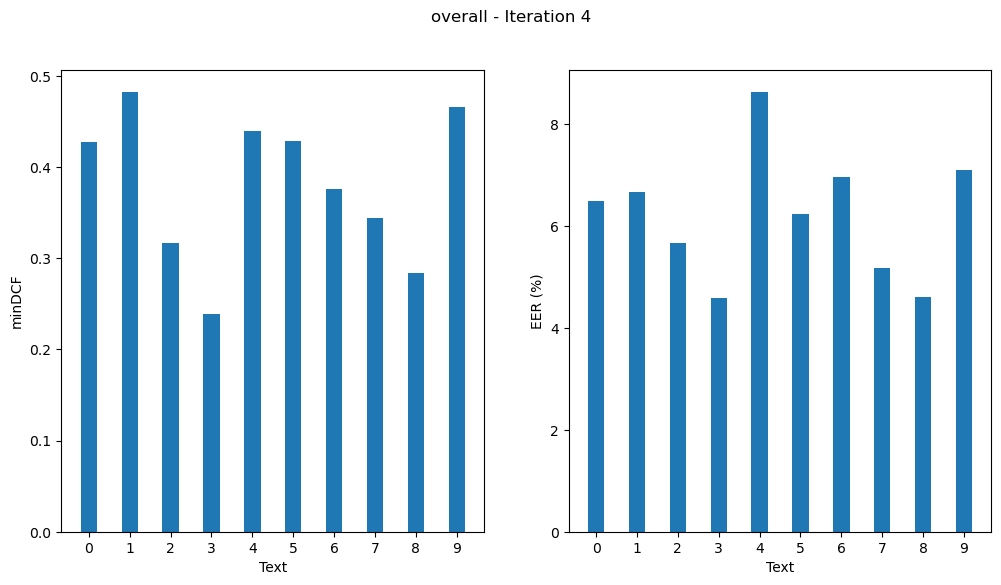

In [125]:
plot_result(df, gender='overall', phase='dev', loop=4)

In [127]:
df_all = pd.DataFrame()
MAX_LOOP = 4
for loop in range(1,MAX_LOOP+1):
    df_all = pd.concat([df_all, pd.read_csv('checkpoints_combine/loop%s/result.csv'%(loop))], ignore_index=True)

In [128]:
df_all

,phase,eer,gender,minDCF,text,loop,word
0,dev,6.740000,female,0.472100,0,1,0
1,dev,6.640000,male,0.379300,0,1,0
2,dev,6.690000,overall,0.425700,0,1,0
3,eval,7.164694,female,0.391229,0,1,0
4,eval,9.046327,male,0.606351,0,1,0
...,...,...,...,...,...,...,...
235,dev,7.810000,male,0.378100,4_4_4_4,4,4
236,dev,8.630000,overall,0.440250,4_4_4_4,4,4
237,eval,10.581327,female,0.500278,4_4_4_4,4,4
238,eval,7.802781,male,0.361082,4_4_4_4,4,4


In [139]:
def get_result(data,max_loop=5):
    result = {
    }
    genders = ['female','male','overall']
    phases = ['dev', 'eval']
    words = [x for x in range(0,10)]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result

                

    

In [141]:
result = get_result(df_all, max_loop=4)

In [142]:
json.dump(result, open('results/result_stage2.json', 'w'))